In [1]:
import math, random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from game import SnakeGameAI, Direction, Point
import pygame
import os
import time
from helper import plot



import matplotlib.pyplot as plt
from IPython.display import clear_output
from IPython import display

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
%matplotlib inline

<h3>Use Cuda</h3>

In [3]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

<h2>Replay Buffer</h2>

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

<h2>Cart Pole Environment</h2>

env_id = "CartPole-v0"
env = gym.make(env_id)

print(env.action_space.n)
print(env.observation_space.shape[0])

<h2>Deep Q Network</h2>

model = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

<h2>Computing Temporal Difference Loss</h2>

In [5]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(np.float32(state).transpose((0,3,2,1)))
    next_state = torch.FloatTensor(np.float32(next_state).transpose((0,3,2,1)))
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)

    q_values      = model(state.to(device))
    next_q_values = model(next_state.to(device))

    q_value          = q_values.gather(1, action.unsqueeze(1).to(device)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward.to(device) + gamma * next_q_value * (1 - done.to(device))
    
    #loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    loss = criterion(q_value, expected_q_value)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    
    return loss

<h2>Training</h2>

<p><hr></p>

<h1>Atari Environment</h1>

from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

env_id = "PongNoFrameskip-v4"
env    = gym.make(env_id)

print(env.action_space.n)
print(env.observation_space.shape)
print(env.reset().shape)

In [6]:
def save(model, file_name='BetaAtari1.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(model.state_dict(), file_name)

In [7]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.x_shape = 1152
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride = 3)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.x_shape , 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
    
   
    def act(self, state, epsilon, device):
        if random.random() > epsilon:
            state   = torch.FloatTensor(np.float32(state).transpose((2,1,0))).unsqueeze(0)
            q_value = self.forward(state.to(device))
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(3)
        return action

In [8]:
def action_array(action):
    if (action < 3):
        move = np.zeros(3).astype(np.int)
        move[action] = 1
        #move = move.tolist()
        return move.tolist()
    else:
        print("exceed number of actions\n")
        return

In [9]:
model = CnnDQN(3, 3).to(device)

lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.SmoothL1Loss ()


replay_initial = 1000
replay_buffer = ReplayBuffer(3500)

In [10]:
epsilon_start = 1.0
epsilon_final = 0.001
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

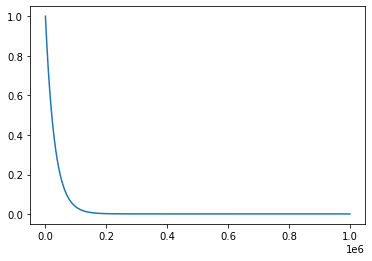

In [11]:
plt.plot([epsilon_by_frame(i) for i in range(1000000)])

<Figure size 432x288 with 0 Axes>

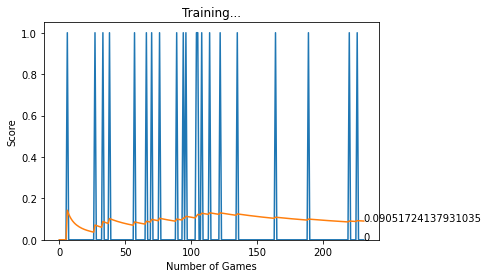

NameError: name 'quit' is not defined

In [12]:
# start:
game = SnakeGameAI()
num_frames = 30000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

plot_scores = []
plot_mean_scores = []
losses = []
loss_episode = []

total_score = 0
episode_reward = 0
out = 0
episode = 0
record = 0

#game = SnakeGameAI()
move = np.zeros(3).astype(np.int)
move = move.tolist()
_, _, _, array3D = game.play_step(move) # No.0
state = array3D

#state = env.reset()
for frame_idx in range(1, num_frames + 1):
    
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon, device)
    
    move = action_array(action)
    
    reward, done, score, next_state = game.play_step(move) # No.2
    #next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        game.reset()
        episode += 1
        all_rewards.append(episode_reward)
        episode_reward = 0
        
        if score > record:
            record = score
            save(model)

        print('Game', episode, 'Score', score, 'Record:', record)

        plot_scores.append(score)
        total_score += score
        
        mean_score = total_score / episode
        plot_mean_scores.append(mean_score)
        
        #loss_episode.append(np.mean(losses))
        #losses = []
        plot(plot_scores, plot_mean_scores)
        
        
        
    if len(replay_buffer) > 100:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
        
        
game.reset()
print('Final Score', score)
pygame.display.quit() 
pygame.quit()


In [13]:
pygame.display.quit() 
pygame.quit()

In [13]:
losses

[4.102204322814941,
 2.778341770172119,
 4.427209377288818,
 3.9856131076812744,
 0.9455414414405823,
 3.839010715484619,
 1.0144062042236328,
 3.661304235458374,
 0.3386251926422119,
 3.381108283996582,
 6.305063724517822,
 0.4243011176586151,
 3.4734902381896973,
 0.4171299934387207,
 0.38161706924438477,
 6.383352279663086,
 0.3058302700519562,
 3.1885905265808105,
 0.32609349489212036,
 3.03987717628479,
 5.96135139465332,
 6.094084739685059,
 3.3146066665649414,
 3.3701939582824707,
 3.07144832611084,
 0.22473713755607605,
 0.12837983667850494,
 2.9749081134796143,
 5.873420715332031,
 2.9304006099700928,
 5.706548690795898,
 0.15198124945163727,
 0.17523084580898285,
 3.111734390258789,
 2.9558770656585693,
 0.2638906240463257,
 2.85088849067688,
 0.18450480699539185,
 0.11733826249837875,
 2.868929386138916,
 2.710672378540039,
 2.9130916595458984,
 11.056265830993652,
 0.10430067777633667,
 0.11709492653608322,
 2.7820334434509277,
 0.14926362037658691,
 2.7930188179016113,
 0.

In [18]:
s1 = torch.FloatTensor(np.float32(state).transpose((2,0,1))
print(s1.shape)
print(next_state.shape)

torch.Size([1, 3, 210, 160])
(210, 160, 3)


In [15]:
replay_buffer.__len__()

3500

In [16]:
all_rewards

[]

In [17]:
env.close()

In [17]:
state, action, reward, next_state, done = replay_buffer.sample(batch_size)
 
state      = torch.FloatTensor(np.float32(state))
print(state.view(state.size(0),-1).shape)

torch.Size([32, 100800])
